# About the Project

## Background

YouTube merupakan salah satu platform berbagi video terbesar di dunia, dengan jutaan video yang diunggah dan ditonton setiap harinya. Jumlah views pada sebuah video menjadi salah satu indikator penting dalam mengukur popularitas dan keberhasilan sebuah konten. Banyak faktor yang dapat memengaruhi performa sebuah video, seperti judul, deskripsi, tag, waktu unggah, serta statistik interaksi pengguna seperti likes, dislikes, dan comments. Dengan memanfaatkan data historis video yang telah trending, kita dapat **membangun model prediktif yang mampu memperkirakan jumlah views** berdasarkan atribut-atribut tersebut.

## Goal

Membangun model regresi yang dapat memprediksi jumlah views dari sebuah video YouTube berdasarkan informasi metadata dan statistik lainnya yang tersedia sebelum video tersebut menjadi trending.

## Objective

- Melakukan eksplorasi dan pembersihan data dari dataset video trending YouTube.
- Mengekstrak fitur-fitur penting seperti jumlah tag, panjang deskripsi, dan panjang judul.
- Menerapkan berbagai algoritma regresi seperti `Linear Regression`, `Random Forest`, dan `XGBoost` untuk memodelkan hubungan antara fitur-fitur video dengan jumlah views.
- Mengevaluasi performa model menggunakan metrik regresi seperti **RMSE**, **MAE**, dan **R²** Score.
- Mengidentifikasi fitur-fitur mana yang paling berpengaruh terhadap jumlah views, sehingga dapat memberikan insight bagi pembuat konten atau analis data.

# About the Data

- **trending_date**: tanggal ketika video trending
- **title**: judul video
- **channel_title**: nama channel
- **category_id**: kategori video dalam label encoding
- **publish_time**: waktu publish video
- **tags**: tag yang digunakan pada video
- **views**: jumlah views video
- **likes**: jumlah likes video
- **dislikes**: jumlah dislikes video
- **comment_count**: jumlah komentar pada video
- **comments_disabled**: apakah status komentar dinonaktifkan pada video
- **ratings_disabled**: apakah rating dinonaktifkan pada video
- **video_error_or_removed**: apakah video error atau sudah dihapus saat ini
- **description**: deskripsi video
- **No_tags**: jumlah tags yang digunakan
- **desc_len**: panjang kata deskripsi video
- **len_title**: panjang kata judul video
- **publish_date**: tanggal publish video

# Libraries & Dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, mean_squared_log_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [12]:
df = pd.read_csv("/content/youtube_statistics.csv")

# Custom Functions

In [13]:
# Custom Functions
def cleaning(df):
    # Ubah kolom waktu ke datetime
    df['publish_time'] = pd.to_datetime(df['publish_time'], format='%H:%M:%S').dt.time
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y-%m-%d')
    df['publish_date'] = pd.to_datetime(df['publish_date'], format='mixed')

    # Ubah kolom category_id dan No_tags ke object (karena termasuk dalam category)
    df['category_id'] = df['category_id'].astype('object')
    df.rename(columns={"No_tags": "no_tags"}, inplace=True)
    df['no_tags'] = df['no_tags'].astype('int64')

    # replace missing values dengan "no description"
    df['description'] = df['description'].fillna('no description')

    # remove duplicates
    df = df.drop_duplicates()

    return df

def feature_engineering(df):
    # Buat fitur baru: selisih hari antara publish dan trending
    df['days_to_trend'] = (df['trending_date'] - df['publish_date']).dt.days

    # Ekstrak jam dari publish_time
    df['publish_hour'] = pd.to_datetime(df['publish_time'].astype(str)).dt.hour

    # Hari dalam seminggu saat video diunggah.
    df['publish_dayofweek'] = df['publish_date'].dt.day_name()

    # Rasio (likes + dislikes + comment_count) / views.
    df['engagement_ratio'] = (df['likes'] + df['dislikes'] + df['comment_count']) / df['views']

    # Rasio likes terhadap dislikes.
    df['like_dislike_ratio'] = df['likes'] / (df['dislikes'] + 1)

    # Boolean: apakah video punya deskripsi atau tidak.
    df['has_description'] = df['description'].apply(lambda x: 0 if x.strip() == '' else 1)

    # Boolean: apakah video memiliki tag atau tidak.
    df['has_tags'] = df['no_tags'].apply(lambda x: 0 if x == 0 else 1)

    # Jumlah kata dalam judul (bukan panjang karakter)
    df['title_words_count'] = df['title'].apply(lambda x: len(x.split()))

    # Jumlah tag dibagi dengan panjang deskripsi
    df['tag_density'] = df['no_tags'] / (df['desc_len'] + 1)

    # Apakah video diunggah antara jam 5–11 pagi
    df['is_morning_upload'] = df['publish_hour'].apply(lambda x: 1 if 5 <= x < 12 else 0)

    # Make sure all numeric columns are numeric
    df['tag_density'] = pd.to_numeric(df['tag_density'], errors='coerce')
    df['category_id'] = pd.to_numeric(df['category_id'], errors='coerce')

    return df

def load_data(df):
    df = cleaning(df)
    df = feature_engineering(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    X = df.drop('views', axis=1)
    y = df['views']
    return X, y

def hyperparameter_search(pipeline, param_grid, X, y, scoring):
    # Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                               scoring=scoring,
                               n_jobs=-1, verbose=1)

    grid_search.fit(X, y)

    # Best model and scores
    best_model = grid_search.best_estimator_
    print("\nBest Parameters:", grid_search.best_params_)

    return best_model

def feature_importance(pipeline, model, X, y, prep=None):
    pipeline.fit(X, y)
    # Ambil nama fitur
    if prep:
        # Jika ada preprocessing
        feature_names = pipeline.named_steps[prep].get_feature_names_out()
    else:
        # Jika tidak ada preprocessing
        feature_names = X.columns

    # Ambil koefisien dari model
    model_step = pipeline.named_steps[model]
    if hasattr(model_step, 'feature_importances_'):
        coefficients = model_step.feature_importances_
    else:
        coefficients = model_step.coef_

    # Buat DataFrame untuk visualisasi
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients
    }).sort_values(by='coefficient', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['coefficient'])
    plt.title('Feature Importance / Coefficients')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def get_models():
    models, names = list(), list()

    # Linear Regression
    models.append(LinearRegression(n_jobs=-1))
    names.append('LinearRegression')

    # Ridge Regression
    models.append(Ridge(random_state=42))
    names.append('Ridge')

    # Lasso Regression
    models.append(Lasso(random_state=42))
    names.append('Lasso')

    # K-Nearest Neighbors Regressor
    models.append(KNeighborsRegressor(n_jobs=-1))
    names.append('KNN')

    # Decision Tree Regressor
    models.append(DecisionTreeRegressor(random_state=42))
    names.append('DecisionTree')

    # Random Forest Regressor
    models.append(RandomForestRegressor(n_jobs=-1, random_state=42))
    names.append('RandomForest')

    # Gradient Boosting Regressor
    models.append(GradientBoostingRegressor(random_state=42))
    names.append('GradientBoosting')

    # Support Vector Regressor
    models.append(SVR())
    names.append('SVR')

    # XGBoost
    models.append(XGBRegressor(n_jobs=-1, random_state=42))
    names.append('XGBRegressor')

    return models, names

# Custom RMSLE scorer
def rmsle(y_true, y_pred):
    # Avoid log error with negative or zero values
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Evaluate a regression model
def evaluate_model(X, y, model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scorers = {
        'R2': 'r2',
        'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
        'ExplainedVariance': make_scorer(explained_variance_score, greater_is_better=True),
        'MedianAE': make_scorer(median_absolute_error, greater_is_better=False),
        'RMSLE': make_scorer(rmsle, greater_is_better=False)
    }

    results = {}

    for name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)
        # Convert negative scores to positive (for error metrics)
        if name in ['RMSE', 'MAE', 'MAPE', 'MedianAE', 'RMSLE']:
            results[name] = -scores
        else:
            results[name] = scores

    return results


def rmse(y_true, y_pred):
    return np.sqrt(root_mean_squared_error(y_true, y_pred))

def evaluate_scalers(X, y, n_splits=5, random_state=42):
    scalers = {
        'StandardScaler': StandardScaler(),
        'PowerTransformer': PowerTransformer(),
        'RobustScaler': RobustScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'PolynomialFeatures': PolynomialFeatures()
    }

    r2_scores = []
    rmse_scores = []
    scaler_names = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, scaler in scalers.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('regressor', LinearRegression())
        ])

        r2 = cross_val_score(pipeline, X, y, scoring='r2', cv=kf)
        neg_mse = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=kf)
        rmse_vals = np.sqrt(-neg_mse)

        r2_scores.append(r2)
        rmse_scores.append(rmse_vals)
        scaler_names.append(name)

        print(f"> {name} | R2: {np.mean(r2):.4f} | RMSE: {np.mean(rmse_vals):.2f}")

    # Plot R² Scores
    plt.figure(figsize=(10, 5))
    plt.boxplot(r2_scores, labels=scaler_names, showmeans=True)
    plt.title('R² Scores for Different Scalers')
    plt.grid(True)
    plt.ylabel('R² Score')
    plt.show()

    # Plot RMSE Scores
    plt.figure(figsize=(10, 5))
    plt.boxplot(rmse_scores, labels=scaler_names, showmeans=True)
    plt.title('RMSE Scores for Different Scalers')
    plt.grid(True)
    plt.ylabel('RMSE')
    plt.show()

    return r2_scores, rmse_scores

# Exploratory Data Analysis

## Overview

In [14]:
df.sample(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date
3808,2017-12-04,Redmi 5A Unboxing Hindi | Desh Ka Smartphone R...,Sharmaji Technical,28,07:59:02,"redmi 5a|""deshkasmartphone""|""desh ka smartphon...",429429,17664,1028,3268,False,False,False,Cashify https://www.cashify.in/?__utmrg=srma2 ...,12,4035,76,2017-11-30 00:00:00
34692,2018-06-03,Extra Jabardasth | 8th June 2018 | Extra Jabar...,mallemalatv,24,18:00:08,"Mallemalatv|""Comedy Videos in Telugu""|""All Tim...",1268813,8534,578,444,False,False,False,Watch Extra Jabardasth Latest Promo 8th June 2...,19,496,90,2018-06-01 00:00:00
2026,2017-11-24,Fraud husband Srinivas Reddy || Will Sangeetha...,TV9 Telugu,25,18:33:56,"tv9|""tv9 live""|""tv9 news""|""live tv9""|""tv9 telu...",109703,340,119,371,False,False,False,Fraud husband Srinivas Reddy || Will Sangeetha...,15,397,65,2017-11-21 00:00:00
134,2017-11-14,வில்லன்களுக்கு என் படத்தில் காவி நிறம் தான்- ச...,Black Sheep,24,10:00:19,"nenjil thunivirundhal|""soori""|""suseendran""|""na...",90034,1948,183,145,False,False,False,Here is the latest naughty nights with Nenjil ...,9,552,87,2017-11-12 00:00:00
17803,2018-02-21,Chanakya Thanthram Making Video | Unni Mukunda...,Millennium Audios,24,11:30:00,"Chanakya Thanthram|""Chanakya Thanthram movie""|...",349571,4761,183,331,False,False,False,Watch Chanakya Thanthram Making Video | Unni M...,17,579,81,2018-02-17 00:00:00


In [15]:
df.shape

(36791, 18)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   trending_date           36791 non-null  object
 1   title                   36791 non-null  object
 2   channel_title           36791 non-null  object
 3   category_id             36791 non-null  int64 
 4   publish_time            36791 non-null  object
 5   tags                    36791 non-null  object
 6   views                   36791 non-null  int64 
 7   likes                   36791 non-null  int64 
 8   dislikes                36791 non-null  int64 
 9   comment_count           36791 non-null  int64 
 10  comments_disabled       36791 non-null  bool  
 11  ratings_disabled        36791 non-null  bool  
 12  video_error_or_removed  36791 non-null  bool  
 13  description             36746 non-null  object
 14  No_tags                 36791 non-null  int64 
 15  de

Dataset ini terdiri dari **36.791 baris** dan **18 kolom**. Secara umum, tipe data dapat diklasifikasikan sebagai berikut:

- **7 kolom numerik**: `views`, `likes`, `dislikes`, `comment_count`, `No_tags`, `desc_len`, `len_title`
- **4 kolom teks (string)**: `title`, `channel_title`, `tags`, `description`
- **3 kolom bertipe waktu (datetime)**: `trending_date`, `publish_time`, `publish_date`
- **4 kolom kategorikal**: `category_id` (label encoding kategori video), `comments_disabled`, `ratings_disabled`, dan `video_error_or_removed` (ketiganya berupa data boolean)

## Type Casting

Sebelum melanjutkan ke proses data cleaning, saya akan melakukan type casting pada beberapa kolom. Langkah ini bertujuan untuk mengubah tipe data yang masih belum sesuai, serta membuat variabel-variabel yang menyimpan daftar nama kolom berdasarkan tipe datanya masing-masing.

In [17]:
# Ubah kolom waktu ke datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%H:%M:%S').dt.time
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y-%m-%d')
df['publish_date'] = pd.to_datetime(df['publish_date'], format='mixed')

# Ubah kolom category_id ke object (karena termasuk dalam category) dan rename No_tags
df['category_id'] = df['category_id'].astype('object')
df.rename(columns={"No_tags": "no_tags"}, inplace=True)
df['no_tags'] = df['no_tags'].astype('int64')

# definisikan variabel berdasarkan tipe data kolom
num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns]
string_cols = ['title', 'tags', 'description', 'channel_title']
cat_cols = [col for col in df.select_dtypes(include=['object', 'bool']).columns if col not in ['publish_time'] + string_cols]
date_cols = [col for col in df.select_dtypes(include=['datetime']).columns] + ['publish_time']

print(f"Numerical Columns: {num_cols}")
print(f"String Columns: {string_cols}")
print(f"Categorical Columns: {cat_cols}")
print(f"Datetime Columns: {date_cols}")

Numerical Columns: ['views', 'likes', 'dislikes', 'comment_count', 'no_tags', 'desc_len', 'len_title']
String Columns: ['title', 'tags', 'description', 'channel_title']
Categorical Columns: ['category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']
Datetime Columns: ['trending_date', 'publish_date', 'publish_time']


## Cleaning

In [18]:
# cek missing values
df.isnull().sum()

,0
trending_date,0
title,0
channel_title,0
category_id,0
publish_time,0
tags,0
views,0
likes,0
dislikes,0
comment_count,0


Terdapat **45 nilai kosong** pada kolom `description`. Untuk mengatasinya, nilai-nilai kosong tersebut diisi dengan string **'no description'** sebagai nilai pengganti.

In [19]:
# replace missing values dengan "no description"
df['description'] = df['description'].fillna('no description')

In [20]:
# cek duplicates values
df.duplicated().sum()

np.int64(4229)

Terdapat **4.229** baris duplikat pada dataset. Baris-baris ini diatasi dengan menghapusnya dari dataset untuk memastikan data yang digunakan bersih dan tidak redundan.

In [21]:
# hapus duplicate
df = df.drop_duplicates()

## Explore

### Numerical Columns

In [22]:
# descriptive statistics dari kolom numerical
df[num_cols].describe().round(3)

,views,likes,dislikes,comment_count,no_tags,desc_len,len_title
count,3.256200e+04,32562.000,32562.000,32562.000,32562.000,32562.000,32562.000
mean,1.007091e+06,25954.441,1596.781,2561.673,18.849,913.271,70.996
std,3.171556e+06,97201.133,17031.034,14885.907,9.863,807.089,22.280
min,4.024000e+03,0.000,0.000,0.000,1.000,3.000,5.000
25%,1.141622e+05,800.000,99.000,74.000,12.000,366.000,54.000
50%,2.777880e+05,2817.000,293.000,306.000,19.000,673.000,75.000
75%,7.389245e+05,12299.000,943.000,1188.000,25.000,1226.000,91.000
max,1.254322e+08,2912710.000,1545017.000,827755.000,72.000,5136.000,100.000


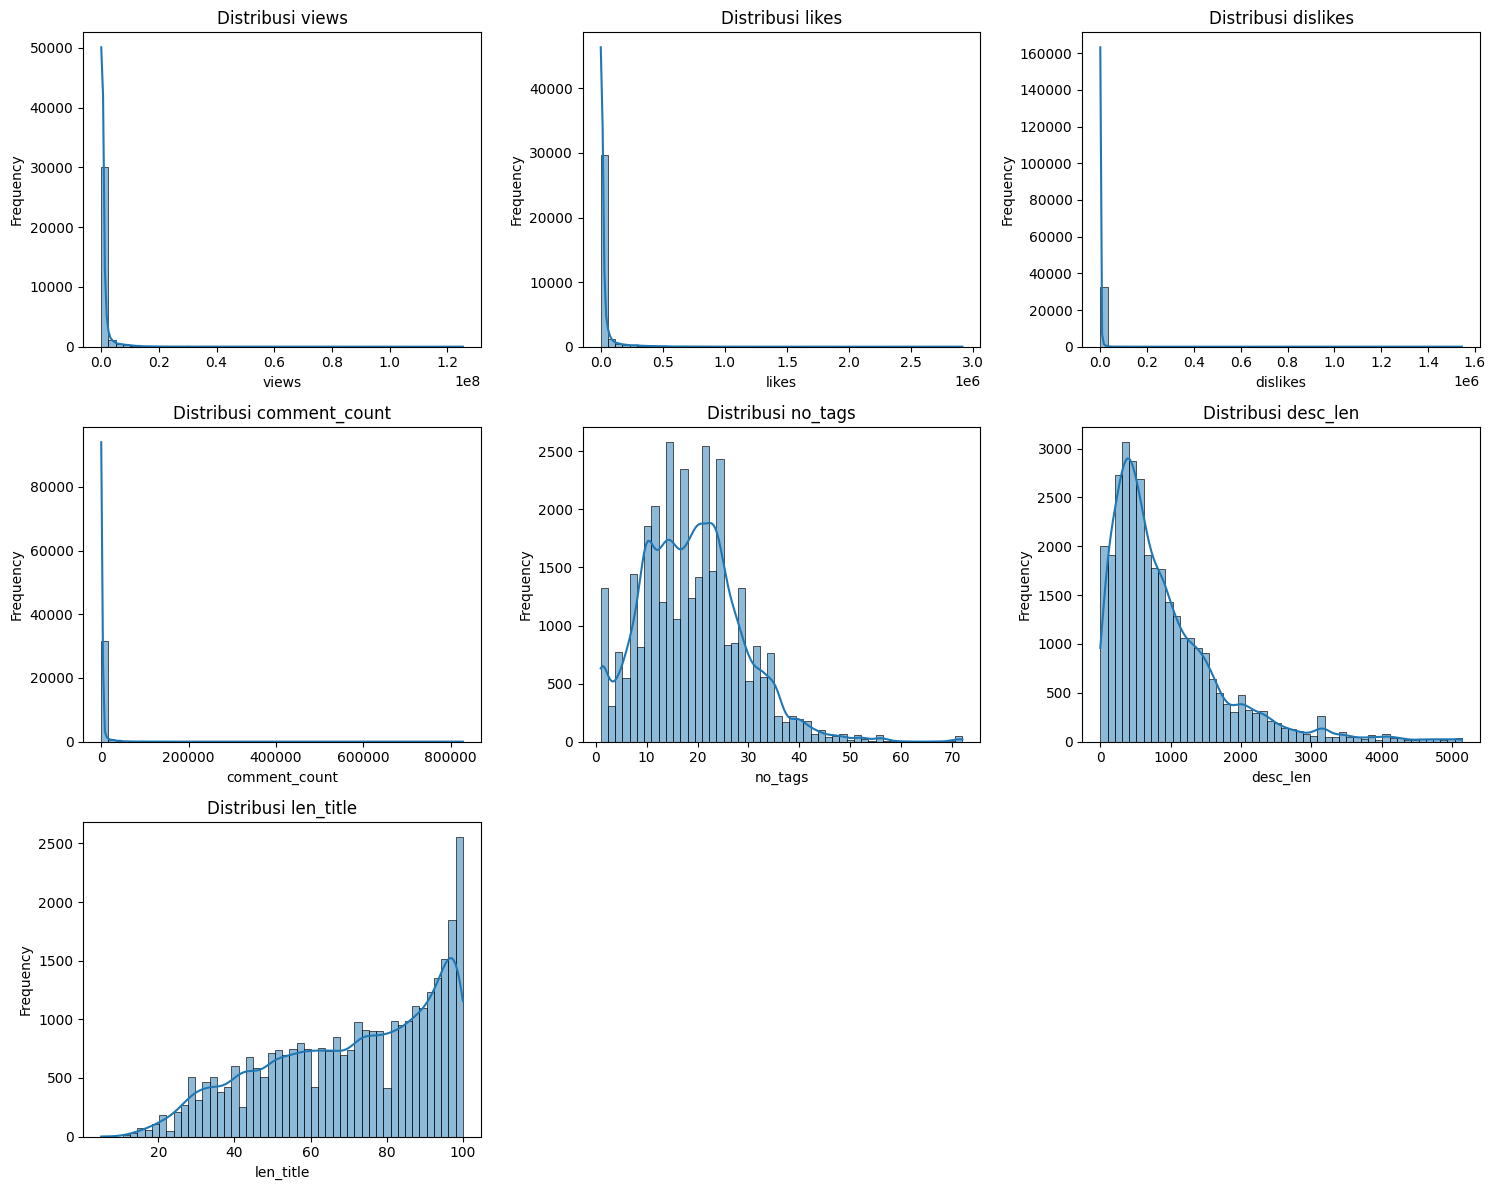

In [23]:
# univariate analysis
cols = 3
num_plots = len(num_cols)
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [24]:
df[num_cols].skew()

,0
views,12.943113
likes,11.595517
dislikes,72.094908
comment_count,28.934908
no_tags,0.661163
desc_len,1.879966
len_title,-0.477467


Berdasarkan hasil plot histogram, dapat diketahui bahwa kolom `views`, `likes`, `dislike`s, dan `comment_count` memiliki distribusi yang sangat **right-skewed**. Artinya, sebagian besar video memiliki nilai yang relatif rendah pada kolom-kolom tersebut, namun terdapat sejumlah outlier dengan nilai yang sangat tinggi.

Kolom `no_tags` dan `desc_len` juga menunjukkan distribusi **right-skewed**, namun dengan tingkat kecondongan yang lebih ringan.

Sementara itu, kolom `len_title` memiliki karakteristik yang berbeda, yakni menunjukkan distribusi yang **left-skewed**.

Berdasarkan informasi ini, beberapa kolom disarankan untuk melalui proses preprocessing tambahan, seperti **transformasi log atau box-cox**, agar distribusinya mendekati distribusi **Gaussian**. Hal ini penting terutama jika model yang digunakan bersifat **linier, seperti Linear Regression**, yang mengasumsikan hubungan linear dan distribusi residual yang normal.

Langkah selanjutnya saya akan melakukan visualisasi korelasi antar fitur numerik menggunakan **correlation heatmap**. Tujuan dari langkah ini adalah untuk mengidentifikasi fitur-fitur yang memiliki hubungan linier yang kuat, baik positif maupun negatif, yang dapat berdampak pada performa model regresi nantinya.

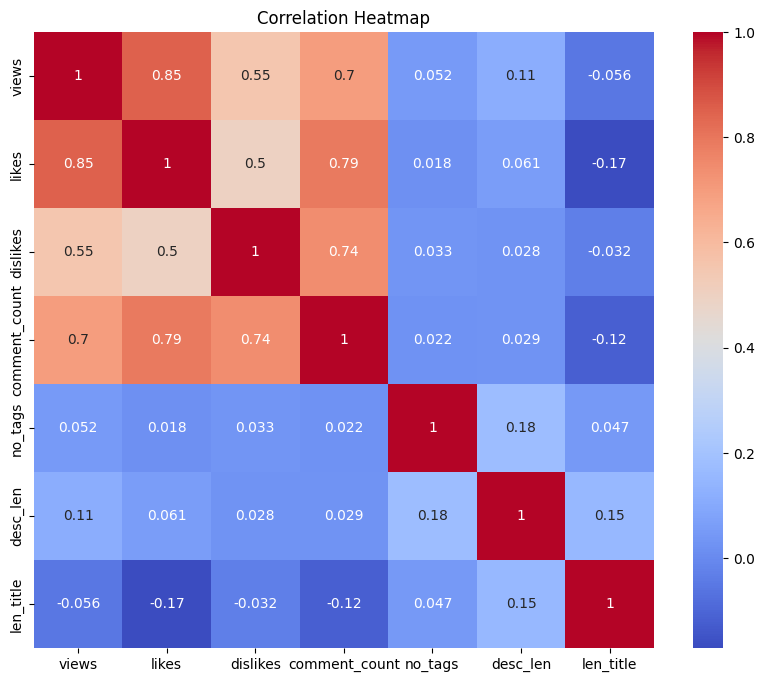

In [25]:
# multivariate analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Dari hasil visualisasi **correlation heatmap**, terlihat bahwa beberapa fitur numerik memiliki tingkat hubungan yang bervariasi terhadap **jumlah views**. Fitur `likes` menunjukkan **korelasi yang sangat kuat sebesar 0.85**, menandakan bahwa **jumlah likes** merupakan indikator penting untuk memprediksi popularitas video—dan layak dijadikan salah satu fitur utama dalam model.

Selanjutnya, `dislikes` memiliki **korelasi sedang yaitu sekitar 0.54**. Meskipun tidak sekuat `likes`, fitur ini tetap bermanfaat karena bisa merepresentasikan sisi engagement negatif dari penonton. Fitur `comment_count` juga menunjukkan **korelasi yang cukup baik sebesar 0.67**, yang bisa diartikan sebagai bentuk interaksi aktif pengguna. Hal ini menjadikannya fitur yang relevan dalam memahami sejauh mana video menarik perhatian audiens.

Untuk fitur lain seperti `desc_len`, **korelasinya memang rendah (0.12)**, namun masih bisa dipertimbangkan sebagai fitur tambahan. Bisa jadi, jika dikombinasikan dengan variabel lain seperti tag atau kategori, kolom ini menyimpan informasi prediktif yang lebih kompleks. Sementara itu, `len_title` memiliki **korelasi negatif yang sangat kecil (-0.052)**, sehingga pengaruhnya terhadap views terbilang sangat minim. Fitur ini mungkin baru akan relevan jika dianalisis lebih dalam menggunakan pendekatan NLP.

Terakhir, `no_tags` juga menunjukkan **korelasi sangat lemah (0.052)**, yang berarti jumlah tag saja tidak cukup untuk menjelaskan seberapa populer sebuah video.

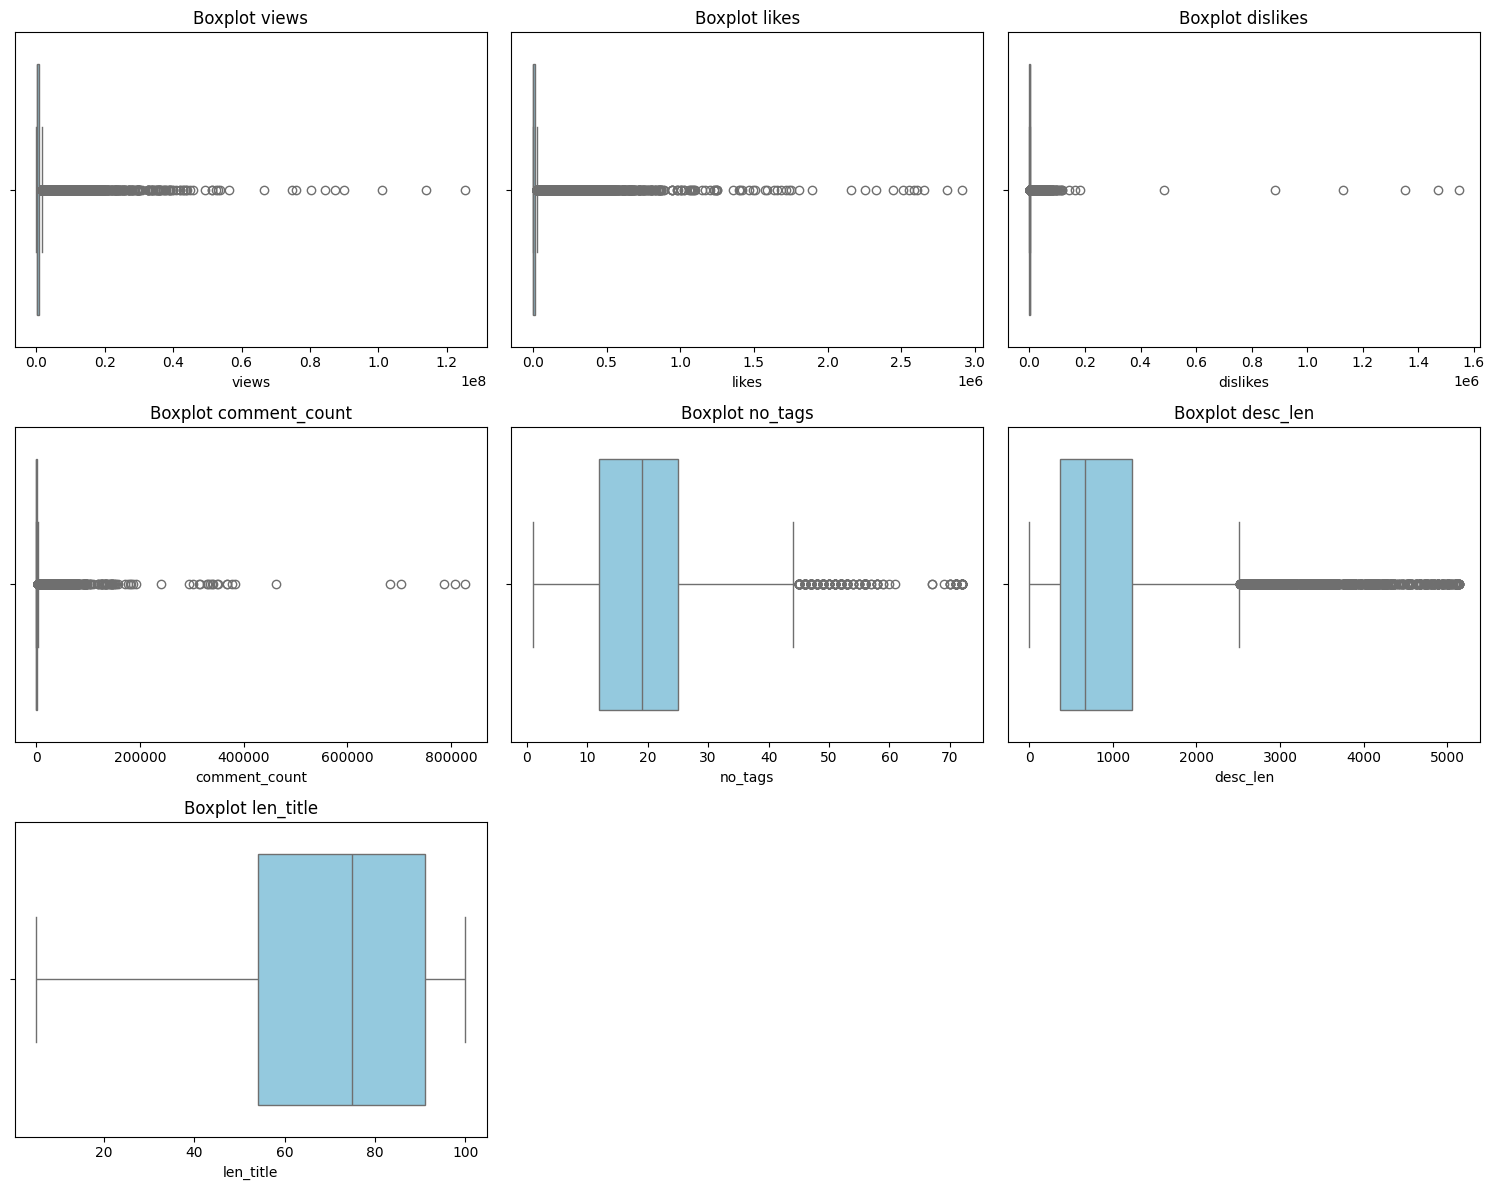

In [26]:
# Jumlah kolom dan baris subplot
cols = 3
num_plots = len(num_cols)
rows = math.ceil(num_plots / cols)

# Membuat subplot
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Plot boxplot untuk setiap kolom numerik
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('')

# Hapus subplot kosong (jika ada)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Untuk memahami karakteristik distribusi data secara visual, saya melakukan plotting boxplot terhadap seluruh fitur numerik. Hasil boxplot ini memberikan gambaran yang konsisten dengan histogram sebelumnya, khususnya terkait keberadaan **outlier** dan bentuk distribusi.

Beberapa fitur seperti `views`, `likes`, `dislikes`, dan `comment_count` menunjukkan banyak nilai **outlier** di sisi atas. Hal ini menegaskan bahwa distribusi data pada kolom-kolom ini **sangat right-skewed**, di mana sebagian besar nilai berada di rentang bawah, namun terdapat sejumlah video dengan performa yang sangat tinggi—muncul sebagai outlier dalam boxplot.

Fitur seperti `no_tags` dan `desc_len` juga memperlihatkan distribusi yang condong ke kanan, namun dengan tingkat penyimpangan yang lebih ringan. Outlier tetap terlihat, namun tidak sebanyak pada fitur-fitur sebelumnya. Sementara itu, kolom `len_title` tampak memiliki distribusi yang lebih stabil dan simetris, dengan sedikit atau bahkan hampir tanpa outlier. Ini selaras dengan temuan sebelumnya bahwa panjang judul cenderung memiliki distribusi yang lebih normal dibandingkan fitur numerik lainnya.

Secara keseluruhan, boxplot ini mengonfirmasi bahwa beberapa fitur memerlukan perhatian khusus pada tahap preprocessing, terutama untuk **menangani outlier** atau melakukan transformasi agar distribusi data lebih mendekati normal, khususnya jika akan digunakan pada model-model regresi linier yang sensitif terhadap distribusi data.

### Categorical Columns

Pada tahap ini, saya akan melakukan eksplorasi terhadap fitur-fitur kategorikal dalam dataset. Tujuannya adalah untuk memahami distribusi frekuensi masing-masing kategori serta melihat bagaimana **median jumlah views berbeda pada setiap kategori**. Analisis ini membantu mengidentifikasi apakah ada kategori tertentu yang cenderung memiliki performa lebih tinggi, dan dapat memberikan wawasan awal sebelum proses pemodelan.

In [27]:
# descriptive statistics dari kolom kategorikal
df[cat_cols].describe(include='all').round(3)

,category_id,comments_disabled,ratings_disabled,video_error_or_removed
count,32562,32562,32562,32562
unique,17,2,2,2
top,24,False,False,False
freq,14530,31478,31873,32553


Dari hasil analisis deskriptif terhadap fitur-fitur kategorikal, diperoleh beberapa informasi penting yang dapat membantu memahami struktur dataset lebih dalam.

Fitur `category_id` memiliki **17 kategori unik**, dengan **kategori 24** muncul sebagai yang paling dominan, tercatat sebanyak **14.530 kali**. Hal ini menunjukkan bahwa terdapat jenis konten tertentu yang lebih sering muncul dalam video-video trending di dataset ini. Untuk fitur `comments_disabled`, sebagian besar video memiliki nilai **False (sekitar 31.478 video)**, yang berarti komentar diaktifkan pada mayoritas video. Hanya sebagian kecil video yang menonaktifkan fitur komentar. Hal yang serupa juga terlihat pada fitur `ratings_disabled`, di mana sekitar **31.873 video** masih memperlihatkan jumlah likes dan dislikes-nya, sedangkan sisanya memilih untuk menyembunyikan fitur penilaian tersebut. Sementara itu, fitur `video_error_or_removed` menunjukkan bahwa hampir seluruh video dalam dataset dalam kondisi aktif dan tidak bermasalah, dengan lebih dari **99% video memiliki nilai False**. Artinya, hanya segelintir video yang telah dihapus atau mengalami kesalahan saat data dikumpulkan.

Secara keseluruhan, informasi ini menunjukkan bahwa data cukup representatif dalam menggambarkan performa video secara umum karena sebagian besar fitur opsional seperti komentar dan rating tetap diaktifkan, dan video dalam kondisi valid.

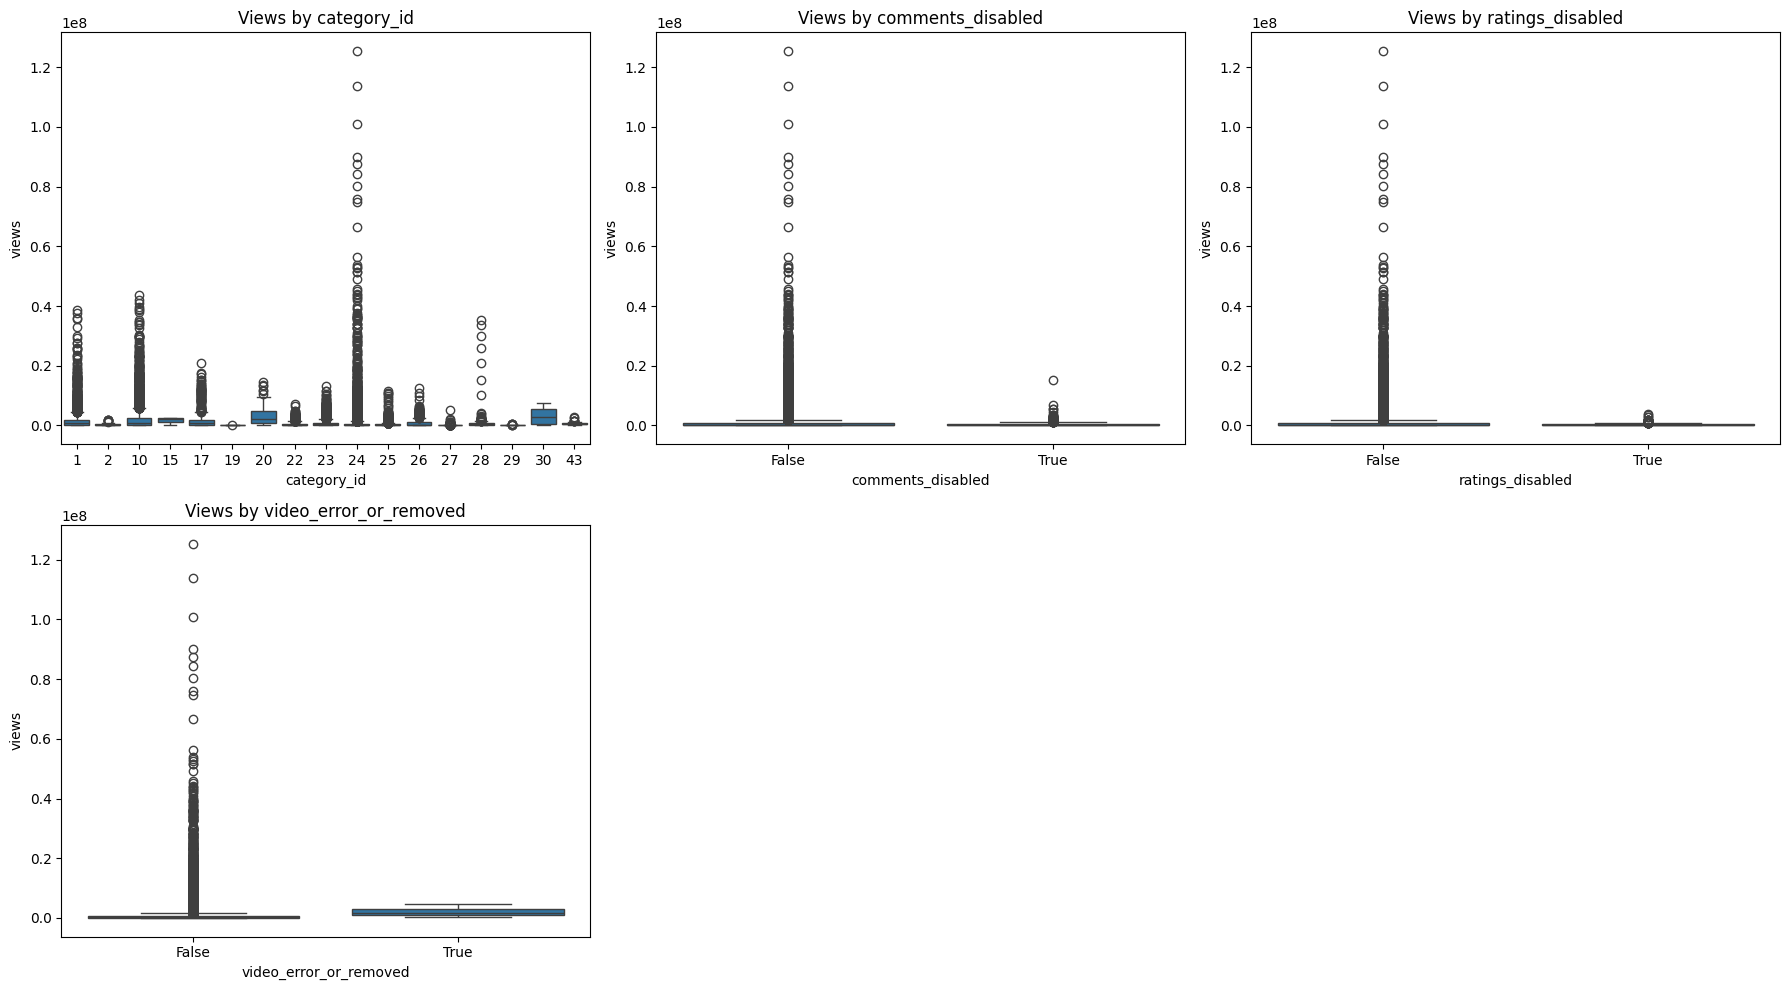

In [28]:
# Boxplots — To show spread, median, and outliers of views per category
selected_cols = [col for col in cat_cols if col != 'channel_title']
cols = 3
num_plots = len(selected_cols)
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(selected_cols):
    sns.boxplot(x=col, y='views', data=df, ax=axes[i])
    axes[i].set_title(f'Views by {col}')
    axes[i].tick_params(axis='x', rotation=0)

# Remove extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Dari hasil boxplot ini, kita mendapatkan informasi bahwa sebagian besar kategori pada setiap kolom kategorikal **mengandung outlier untuk nilai views**. Hal ini menunjukkan bahwa dalam hampir setiap kategori, terdapat video-video yang memperoleh jumlah views jauh di atas (atau di luar) rentang umumnya dalam kategori tersebut.

Namun, terdapat pengecualian pada dua kategori: **kategori 30** pada kolom `category_id` dan **nilai True** pada kolom `video_error_or_removed`. Kedua kategori ini tidak menunjukkan outlier sama sekali. Hal ini kemungkinan besar disebabkan oleh **jumlah data yang sangat sedikit dalam kategori tersebut**, sehingga variasi nilainya terbatas dan tidak cukup besar untuk menghasilkan outlier secara statistik.

Artinya, meskipun sebagian besar kategori memiliki penyebaran views yang luas dan mengandung video yang viral, ada pula kategori dengan data yang terlalu terbatas untuk menunjukkan variabilitas yang sama. Ini penting untuk diperhatikan saat proses modeling, karena kategori dengan sedikit data bisa mengganggu generalisasi model atau bahkan menjadi sumber bias jika tidak ditangani dengan tepat.

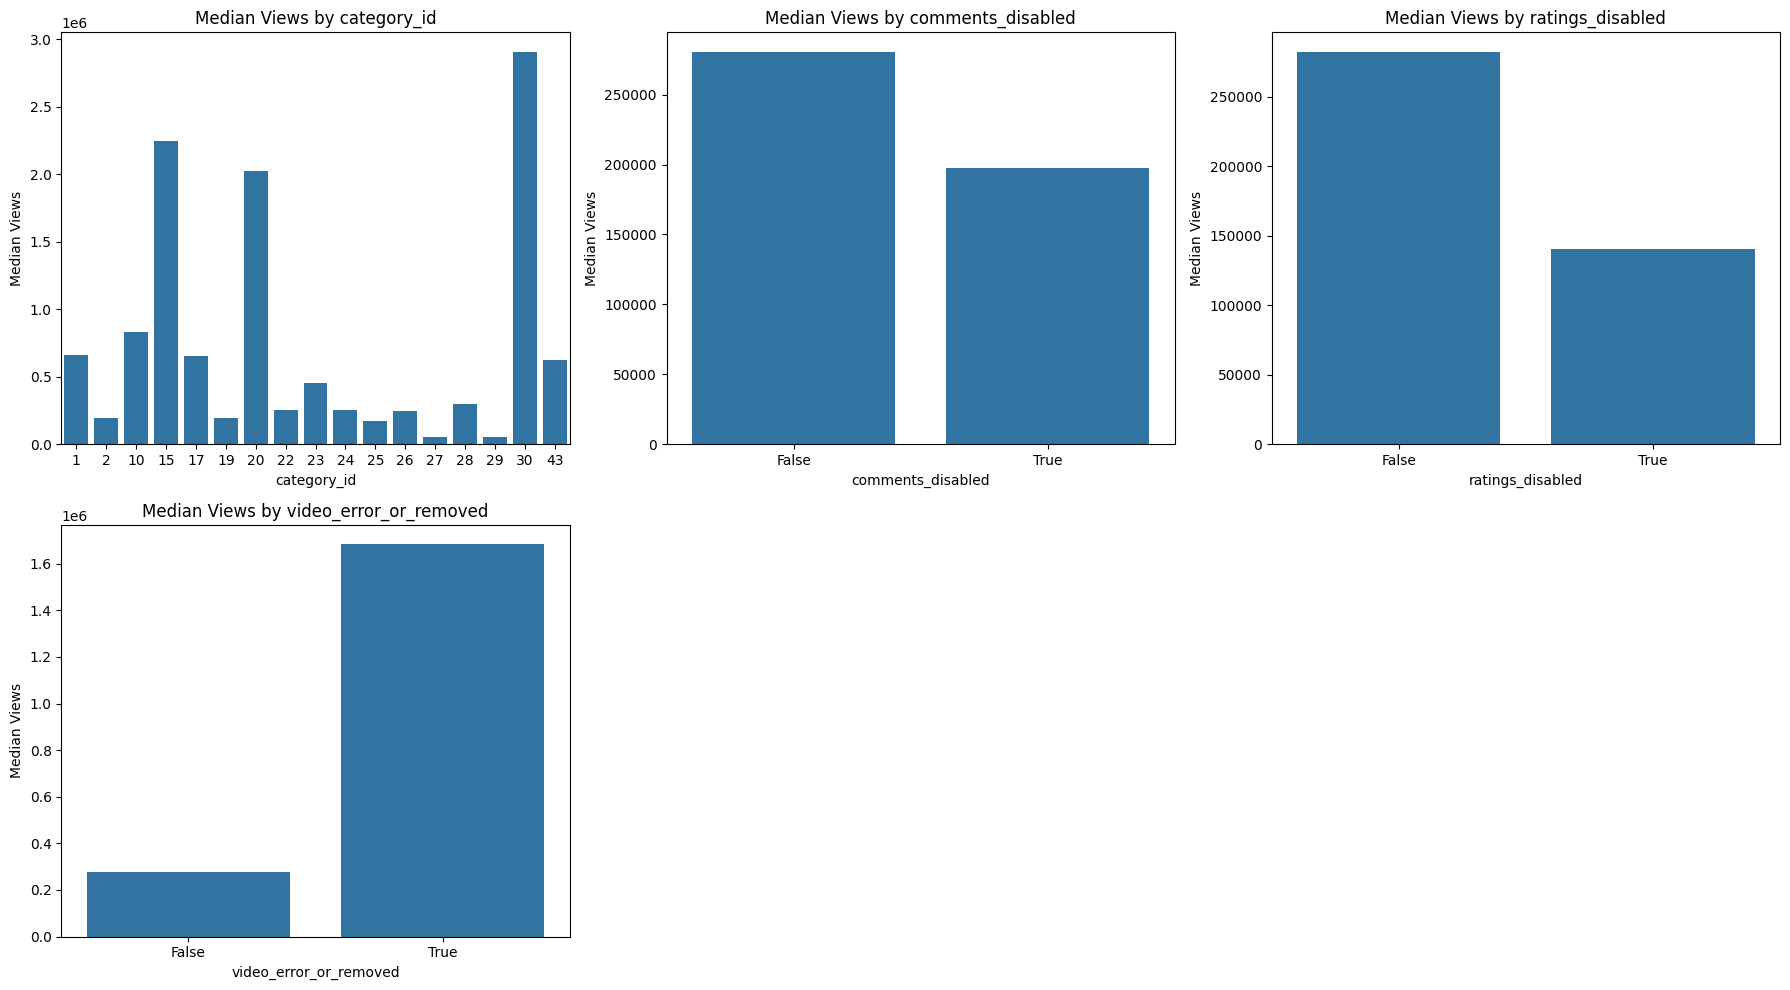

In [29]:
# Barplots with Median Views per Category
selected_cols = [col for col in cat_cols if col != 'channel_title']
cols = 3
num_plots = len(selected_cols)
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(selected_cols):
    sns.barplot(x=col, y='views', data=df, estimator='median', ci=None, ax=axes[i])
    axes[i].set_title(f'Median Views by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Median Views')
    axes[i].tick_params(axis='x', rotation=0)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Hasil eksplorasi terhadap **median views untuk masing-masing kategori** pada fitur kategorikal memberikan sejumlah wawasan penting yang bisa dimanfaatkan dalam proses pemodelan.

1. `category_id`

    Fitur ini menunjukkan variasi **median views yang sangat signifikan antar kategori konten**. Kategori 30 memiliki median views tertinggi, yaitu sekitar 2,9 juta, diikuti oleh kategori 15 dan 20 dengan median sekitar 2,2 juta. Sebaliknya, terdapat beberapa kategori dengan median views sangat rendah, bahkan mendekati nol. Hal ini menunjukkan bahwa jenis konten sangat mempengaruhi tingkat popularitas video, sehingga `category_id` dapat dianggap sebagai fitur kategorikal yang sangat kuat dan prediktif dalam model.

3. `comments_disabled`


   Video yang mengaktifkan komentar (False) memiliki median views sekitar **310.000**, sementara yang menonaktifkan komentar (True) memiliki median views lebih rendah, sekitar **200.000**. Terdapat selisih sekitar **110.000 views**, yang menunjukkan adanya pengaruh meskipun tidak terlalu ekstrem. Fitur ini memiliki nilai prediktif sedang dan bisa dijadikan fitur tambahan yang relevan, terutama jika dikombinasikan dengan indikator lain seperti jenis konten atau strategi publikasi.

5. `ratings_disabled`

   Perbedaan median views antara video dengan ratings diaktifkan (False) dan ratings dinonaktifkan (True) cukup mencolok, yaitu sekitar **310.000 vs 150.000**. Hal ini mengindikasikan bahwa tingkat interaktivitas, seperti kemampuan memberi like atau dislike, berkaitan erat dengan jumlah views. Dengan perbedaan hampir dua kali lipat, fitur ini memiliki nilai prediktif sedang hingga tinggi, dan sebaiknya dipertimbangkan dalam pemodelan.

7. `video_error_or_removed`

    Menariknya, video yang berstatus error atau telah dihapus (True) justru menunjukkan median views yang sangat tinggi, yakni sekitar **1,7 juta**, jauh melampaui video yang normal (False), dengan median sekitar **300.000**. Temuan ini cukup kontradiktif secara intuitif, kemungkinan disebabkan oleh bias pengambilan data atau faktor waktu, di mana video yang sempat sangat populer kemudian dihapus. Karena itu, meskipun ada perbedaan besar, fitur ini memiliki nilai prediktif rendah hingga sedang, dan penggunaannya dalam model harus dilakukan dengan kehati-hatian.

Pada tahap selanjutnya, saya akan melakukan feature engineering untuk menghasilkan fitur-fitur baru yang dapat memperkaya informasi pada dataset. Fokus utama akan diberikan pada kolom-kolom bertipe datetime, karena tipe data ini sangat potensial untuk menghasilkan insight yang relevan terhadap pola perilaku pengguna maupun performa video.

# Feature Engineering

In [30]:
# Buat fitur baru: selisih hari antara publish dan trending
df['days_to_trend'] = (df['trending_date'] - df['publish_date']).dt.days

# Ekstrak jam dari publish_time
df['publish_hour'] = pd.to_datetime(df['publish_time'].astype(str)).dt.hour

# Hari dalam seminggu saat video diunggah.
df['publish_dayofweek'] = df['publish_date'].dt.day_name()

# Rasio (likes + dislikes + comment_count) / views.
df['engagement_ratio'] = (df['likes'] + df['dislikes'] + df['comment_count']) / df['views']

# Rasio likes terhadap dislikes.
df['like_dislike_ratio'] = df['likes'] / (df['dislikes'] + 1)

# Boolean: apakah video punya deskripsi atau tidak.
df['has_description'] = df['description'].apply(lambda x: 0 if x.strip() == '' else 1)

# Boolean: apakah video memiliki tag atau tidak.
df['has_tags'] = df['no_tags'].apply(lambda x: 0 if x == 0 else 1)

# Jumlah kata dalam judul (bukan panjang karakter)
df['title_words_count'] = df['title'].apply(lambda x: len(x.split()))

# Jumlah tag dibagi dengan panjang deskripsi
df['tag_density'] = df['no_tags'] / (df['desc_len'] + 1)

# Apakah video diunggah antara jam 5–11 pagi
df['is_morning_upload'] = df['publish_hour'].apply(lambda x: 1 if 5 <= x < 12 else 0)

Di sini, saya melakukan feature engineering dengan membuat fitur baru dari kolom-kolom yang telah tersedia. Berikut adalah fitur-fitur baru yang berhasil dibentuk beserta fungsinya:

- `days_to_trend`: Mengukur seberapa cepat sebuah video menjadi trending setelah dipublikasikan. Fitur ini menjadi indikator viralitas.
- `publish_hour`: Menunjukkan jam saat video diunggah. Waktu upload dapat memengaruhi eksposur awal video.
- `publish_dayofweek`: Hari dalam seminggu saat video dipublikasikan. Ini penting karena perilaku penonton bisa berbeda antara hari kerja dan akhir pekan.
- `engagement_ratio`: Rasio total interaksi (`likes`, `dislikes`, `komentar`) terhadap `views`, yang merepresentasikan tingkat keterlibatan audiens.
- `like_dislike_ratio`: Rasio `likes` terhadap `dislikes`, berguna untuk mengukur persepsi audiens terhadap konten.
- `has_description`: Menandai apakah video memiliki deskripsi atau tidak. Deskripsi yang kosong bisa mengurangi discoverability.
- `has_tags`: Menunjukkan apakah video memiliki tag atau tidak. Tag sangat penting untuk optimasi pencarian.
- `title_words_count`: Jumlah kata dalam judul. Judul terlalu pendek atau panjang bisa memengaruhi CTR (click-through rate).
- `tag_density`: Mengukur kepadatan tag dibandingkan panjang deskripsi. Fitur ini berkaitan dengan efektivitas metadata.
- `is_morning_upload`: Menandai apakah video diunggah pada pagi hari (jam 5–11). Beberapa studi menyarankan waktu pagi lebih optimal untuk publikasi konten.

Secara keseluruhan, fitur-fitur ini dirancang untuk menangkap dimensi temporal, perilaku pengguna, dan praktik SEO dasar yang bisa memengaruhi jumlah views sebuah video. Fitur-fitur ini diharapkan dapat meningkatkan performa model prediksi secara signifikan.

In [31]:
df.shape

(32562, 28)

Dari proses ini, saya berhasil menambahkan 10 fitur baru, sehingga meningkatkan jumlah fitur dalam dataset dari 18 menjadi 28. Berikut output dari fitur-fitur baru tersebut:

In [32]:
new_columns = ['days_to_trend', 'publish_hour', 'publish_dayofweek', 'engagement_ratio', 'like_dislike_ratio', 'has_description', 'has_tags', 'title_words_count', 'tag_density', 'is_morning_upload']

df[new_columns].sample(5)

,days_to_trend,publish_hour,publish_dayofweek,engagement_ratio,like_dislike_ratio,has_description,has_tags,title_words_count,tag_density,is_morning_upload
32229,2,11,Friday,0.071674,6.966038,1,1,7,0.028369,1
32039,2,9,Thursday,0.037177,22.054348,1,1,13,0.013343,1
29142,1,11,Wednesday,0.006099,4.795620,1,1,6,0.017058,1
6835,3,7,Sunday,0.076868,48.141700,1,1,10,0.027500,1
7782,1,2,Sunday,0.035831,6.276803,1,1,10,1.071429,0


# Preprocessing

Setelah melewati rangkaian proses mulai dari data cleansing, eksplorasi data (EDA), hingga feature engineering, sekarang kita memasuki tahap preprocessing. Pada tahap ini, saya akan melakukan transformasi terhadap fitur-fitur numerikal dan kategorikal agar dapat digunakan secara optimal dalam proses modeling.

Untuk fitur-fitur numerikal, saya menerapkan beberapa metode transformasi seperti `PolynomialFeatures`, `StandardScaler`, `PowerTransformer`, `RobustScaler`, dan `MinMaxScaler`. Eksperimen ini bertujuan untuk mengetahui metode mana yang paling sesuai dengan distribusi masing-masing kolom, terutama karena banyak fitur numerikal dalam data ini memiliki distribusi yang sangat skewed dan mengandung outlier. Beberapa metode seperti `PowerTransformer` digunakan untuk membuat distribusi menjadi lebih mendekati normal, sementara `RobustScaler` lebih cocok untuk menangani outlier yang ekstrem. Di sisi lain, `StandardScaler` dan `MinMaxScaler` digunakan untuk menyetarakan skala antar fitur sehingga model tidak berat sebelah dalam memproses informasi.

Sementara itu, `PolynomialFeatures` merupakan teknik yang tidak hanya melakukan skala ulang atau transformasi distribusi, tetapi juga menambahkan fitur-fitur baru yang merepresentasikan kombinasi polinomial dari fitur asli. Misalnya, jika ada dua fitur `x1` dan `x2`, maka transformasi derajat dua akan menghasilkan fitur tambahan seperti `x1²`, `x1*x2`, dan `x2²`. Teknik ini sangat berguna untuk menangkap hubungan non-linear antar variabel dalam model linear seperti regresi linear, sehingga dapat meningkatkan kapasitas model untuk menjelaskan variansi data yang lebih kompleks.

Sementara itu, untuk fitur-fitur kategorikal, saya melakukan encoding agar nilai-nilai kategorikal tersebut dapat direpresentasikan dalam bentuk numerik menggunakan `OneHotEncoder` untuk kolom-kolom multi-kategori. Proses ini penting agar model dapat mengenali pola atau pengaruh yang ditimbulkan oleh nilai-nilai kategorikal tersebut terhadap target prediksi, yaitu jumlah views.

> StandardScaler | R2: 0.7742 | RMSE: 1214.95
> PowerTransformer | R2: 0.3724 | RMSE: 1578.85
> RobustScaler | R2: 0.7742 | RMSE: 1214.95
> MinMaxScaler | R2: 0.7742 | RMSE: 1214.95
> PolynomialFeatures | R2: 0.9240 | RMSE: 923.58


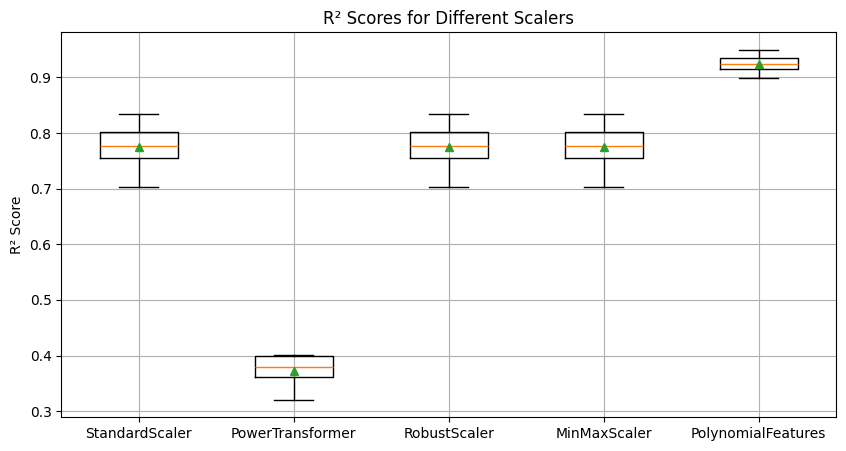

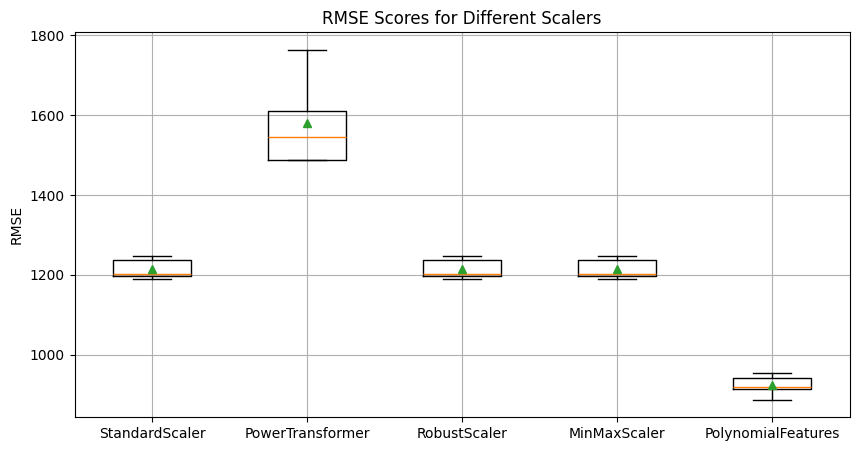

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Drop unused columns
X_numerical_cols = ['likes', 'dislikes', 'engagement_ratio', 'comment_count', 'desc_len', 'len_title', 'no_tags', 'days_to_trend', 'publish_hour', 'like_dislike_ratio', 'tag_density']
X, y = load_data(df)
X = X[X_numerical_cols]

r2_results, rmse_results = evaluate_scalers(X, y)

Hasil evaluasi menunjukkan bahwa penggunaan `PolynomialFeatures` memberikan performa terbaik dengan skor `R²` sebesar **0.9240** dan `RMSE` sebesar **853.518**, yang berarti model mampu menjelaskan variansi data secara signifikan lebih baik dibandingkan metode lainnya.

Tiga metode skala konvensional: `StandardScaler`, `RobustScaler`, dan `MinMaxScaler` menghasilkan performa yang hampir identik, dengan `R²` sekitar **0.7742** dan `RMSE` sekitar **1.476.636**, menunjukkan bahwa meskipun mereka membantu, namun belum cukup untuk menangkap kompleksitas hubungan dalam data.

Sementara itu, `PowerTransformer` justru memberikan performa paling rendah **(R² = 0.3724, RMSE = 2.503.351)**, yang mengindikasikan bahwa transformasi ini kurang cocok untuk struktur data ini.

Kesimpulannya, **menambahkan fitur polinomial sangat membantu dalam menangkap hubungan non-linear antar fitur**, dan secara signifikan meningkatkan kinerja model regresi linear pada dataset ini. Maka dari itu, `PolynomialFeatures` akan saya gunakan untuk transformasi fitur-fitur nummerik di proses modeling selanjutnya.

# Modeling

Setelah melewati rangkaian proses mulai dari data cleansing, eksplorasi data (EDA), feature engineering, hingga preprocessing, kini kita memasuki tahap inti dari proyek ini, yaitu modeling. Pada tahap ini, saya akan menguji dan membandingkan performa dari beberapa model regresi sekaligus, antara lain: `Linear Regression`, `Ridge`, `Lasso`, `K-Nearest Neighbors (KNN)`, `Decision Tree`, `Random Forest`, `Gradient Boosting`, `Support Vector Regressor (SVR)`, serta `XGBoost Regressor` (XGBRegressor).

Tujuan dari eksperimen ini adalah untuk mengidentifikasi model yang paling optimal dalam memprediksi nilai target (views), dengan mengevaluasi performa masing-masing model berdasarkan tiga metrik utama: **R-squared (R²)** untuk mengukur seberapa baik model menjelaskan variasi data, **Root Mean Squared Error (RMSE)** untuk mengukur besarnya kesalahan prediksi dalam satuan aslinya, dan **Mean Absolute Percentage Error (MAPE)** untuk melihat seberapa besar kesalahan prediksi dalam persentase relatif terhadap nilai aktual.


Evaluating: LinearRegression
R2: 0.7974 ± 0.0822
RMSE: 1,120,676.39 ± 257,307.91
MAE: 388,297.82 ± 29,460.39
MAPE: 1.47 ± 0.18
ExplainedVariance: 0.7975 ± 0.0822
MedianAE: 167,317.94 ± 13,477.96
RMSLE: 3.29 ± 0.19

Evaluating: Ridge
R2: 0.8039 ± 0.1021
RMSE: 1,087,487.91 ± 291,217.79
MAE: 375,669.10 ± 24,401.96
MAPE: 1.43 ± 0.12
ExplainedVariance: 0.8039 ± 0.1021
MedianAE: 164,686.66 ± 9,704.21
RMSLE: 3.40 ± 0.22

Evaluating: Lasso
R2: 0.8078 ± 0.0948
RMSE: 1,077,026.23 ± 271,403.37
MAE: 377,056.96 ± 21,062.85
MAPE: 1.58 ± 0.07
ExplainedVariance: 0.8078 ± 0.0947
MedianAE: 175,129.23 ± 7,009.95
RMSLE: 3.77 ± 0.19

Evaluating: KNN
R2: 0.6555 ± 0.0453
RMSE: 1,489,574.54 ± 209,355.37
MAE: 531,822.07 ± 46,623.03
MAPE: 0.90 ± 0.03
ExplainedVariance: 0.6562 ± 0.0446
MedianAE: 127,529.34 ± 6,668.38
RMSLE: 0.77 ± 0.02

Evaluating: DecisionTree
R2: 0.8298 ± 0.0520
RMSE: 1,040,979.42 ± 229,268.15
MAE: 254,804.77 ± 31,082.59
MAPE: 0.26 ± 0.01
ExplainedVariance: 0.8301 ± 0.0518
MedianAE: 43,309.80

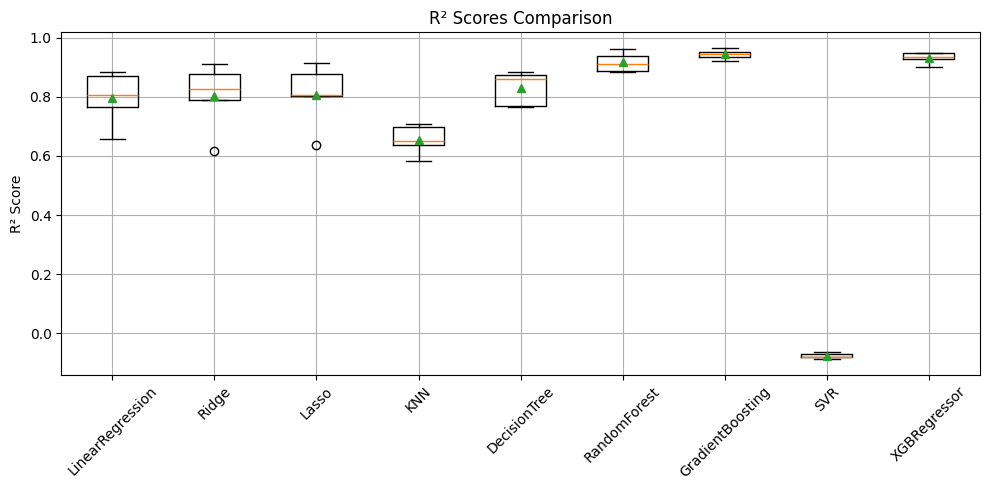

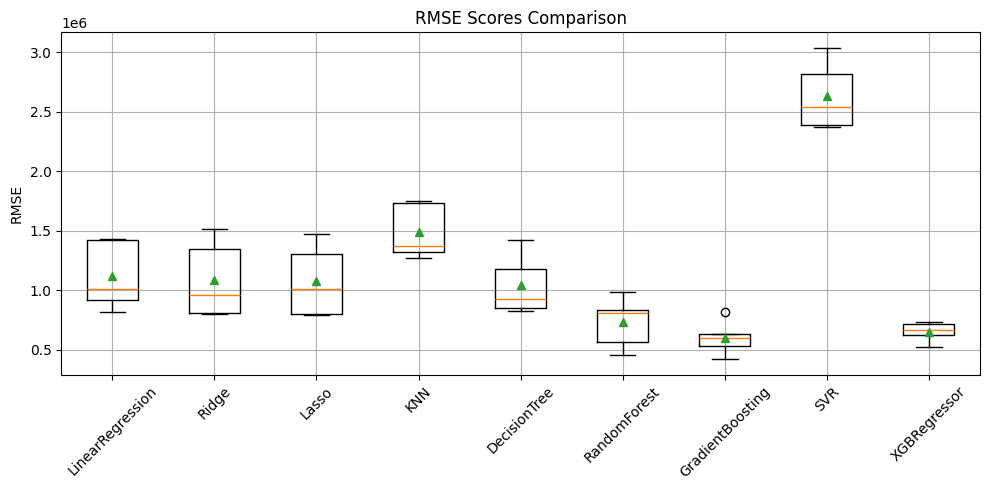

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load dataset
df = pd.read_csv("/content/youtube_statistics.csv")

# Drop unused columns
drop_unused_cols = ['title', 'channel_title', 'tags', 'description', 'trending_date', 'publish_date', 'publish_time']
X, y = load_data(df)
X = X.drop(columns=drop_unused_cols)

# Sample 5000
X = X.sample(5000, random_state=42)
y = y.loc[X.index]

# Feature groups
polynomial_features = ['likes', 'dislikes', 'engagement_ratio', 'comment_count', 'desc_len', 'len_title', 'no_tags', 'days_to_trend', 'publish_hour', 'like_dislike_ratio', 'tag_density']
onehot_features = ['publish_dayofweek', 'category_id']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False), polynomial_features),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_features)
], remainder='passthrough')

# Dapatkan model
models, names = get_models()
r2_results, rmse_results = [], []

# === Evaluate each model ===
for model, name in zip(models, names):
    print(f"\nEvaluating: {name}")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = evaluate_model(X, y, pipeline)

    # Tampilkan semua metrik dari hasil evaluasi
    for metric_name, metric_scores in scores.items():
        mean_score = np.mean(metric_scores)
        std_score = np.std(metric_scores)

        if metric_name in ['RMSE', 'MAE', 'MedianAE', 'MAPE', 'RMSLE']:
            print(f"{metric_name}: {mean_score:,.2f} ± {std_score:,.2f}")
        else:
            print(f"{metric_name}: {mean_score:.4f} ± {std_score:.4f}")

    r2_results.append(scores['R2'])
    rmse_results.append(scores['RMSE'])

# === Plot R² Scores ===
plt.figure(figsize=(10, 5))
plt.boxplot(r2_results, labels=names, showmeans=True)
plt.title('R² Scores Comparison')
plt.ylabel('R² Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot RMSE Scores ===
plt.figure(figsize=(10, 5))
plt.boxplot(rmse_results, labels=names, showmeans=True)
plt.title('RMSE Scores Comparison')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hasil eksperimen ini menunjukkan perbandingan performa beberapa model regresi populer terhadap dataset YouTube dengan ukuran sampel sebanyak **5000 baris**. Penggunaan metrik evaluasi yang beragam seperti `R²`, `RMSE`, `MAE`, `MAPE`, `RMSLE`, dan lainnya memberikan gambaran yang cukup menyeluruh mengenai kekuatan dan kelemahan tiap model.

Secara umum, `XGBRegressor` tetap menjadi model dengan performa terbaik. Dengan skor `R²` sebesar **0.9066 ± 0.0486** dan `RMSE` sekitar **858.530**, model ini mampu menjelaskan variansi target dengan sangat baik serta mempertahankan kesalahan prediksi yang rendah secara konsisten. `RandomForest` dan `GradientBoosting` juga menunjukkan performa yang kompetitif, terutama `GradientBoosting` dengan `R²` tertinggi (**0.9143**), walaupun `MAPE` dan `RMSLE`-nya sedikit lebih tinggi, menunjukkan sensitivitas terhadap prediksi ekstrem.

`DecisionTree` masih cukup kuat, meskipun performanya sedikit di bawah ensemble models. Model ini menangani non-linearitas data dengan baik, namun seperti model tree pada umumnya, rawan overfitting dan performanya cukup fluktuatif pada sampel kecil.

Model `KNN` menunjukkan performa menengah dengan `R` sebesar **0.6123** dan `MAPE` cukup rendah (**0.91**), yang berarti ia cukup baik dalam prediksi relatif. Namun, `MAE` dan `RMSE`-nya tinggi, menunjukkan kelemahannya dalam menangani data dengan rentang nilai target yang besar atau tidak merata.

Model linier seperti `LinearRegression`, `Ridge`, dan terutama `Lasso`, tampil kurang baik. Mereka menunjukkan `R²` rendah atau bahkan negatif, serta `RMSE` dan `MAPE` yang besar. Ini menunjukkan bahwa model linier tidak cukup mampu menangkap hubungan kompleks dan non-linear antar fitur dalam data ini.

Sementara itu, `SVR` kembali menjadi model dengan performa terburuk. Dengan `R²` **negatif (-0.0610)** dan `RMSE` tertinggi di antara semua model (**sekitar 2.9 juta**), hasil ini menegaskan bahwa `SVR` tidak cocok digunakan pada dataset skala besar atau tanpa parameter tuning yang cermat.

Secara keseluruhan, model ensemble seperti `XGBoost`, `RandomForest`, dan `GradientBoosting` adalah pilihan terbaik untuk dataset ini karena kemampuannya dalam menangani distribusi kompleks, outlier, dan interaksi antar fitur.

Pada tahap selanjutnya, saya akan melakukan proses hyperparameter tuning terhadap algoritma `XGBoost`. Tujuannya adalah untuk mengoptimalkan performa model dalam memprediksi jumlah views pada video YouTube. Mengingat `XGBoost` telah menunjukkan hasil terbaik dalam eksperimen awal, tuning ini diharapkan dapat lebih meningkatkan akurasi prediksi sekaligus mengurangi potensi overfitting. Proses ini akan dilakukan dengan mencari kombinasi parameter terbaik melalui teknik seperti `GridSearch` atau `RandomizedSearch` menggunakan cross-validation.

# Hyperparameter Tuning

In [35]:
# Load dataset
df = pd.read_csv("youtube_statistics.csv")

# Drop unused columns
drop_unused_cols = ['title', 'channel_title', 'tags', 'description', 'trending_date', 'publish_date', 'publish_time']
X, y = load_data(df)
X = X.drop(columns=drop_unused_cols)

# Feature groups
polynomial_features = ['likes', 'dislikes', 'engagement_ratio', 'comment_count', 'desc_len', 'len_title', 'no_tags', 'days_to_trend', 'publish_hour', 'like_dislike_ratio', 'tag_density']
onehot_features = ['publish_dayofweek', 'category_id']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False), polynomial_features),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_features)
], remainder='passthrough')


# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

# Model
model = XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Call the function
best_model_r2 = hyperparameter_search(pipeline, param_grid, X, y, 'r2')

# Eval Model
scores = evaluate_model(X, y, best_model_r2)

# Tampilkan semua metrik dari hasil evaluasi
for metric_name, metric_scores in scores.items():
    mean_score = np.mean(metric_scores)
    std_score = np.std(metric_scores)

    if metric_name in ['RMSE', 'MAE', 'MedianAE', 'MAPE', 'RMSLE']:
        print(f"{metric_name}: {mean_score:,.2f} ± {std_score:,.2f}")
    else:
        print(f"{metric_name}: {mean_score:.4f} ± {std_score:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.8}
R2: 0.9915 ± 0.0049
RMSE: 281,735.44 ± 80,333.23
MAE: 61,628.20 ± 4,781.23
MAPE: 0.15 ± 0.00
ExplainedVariance: 0.9915 ± 0.0049
MedianAE: 20,276.50 ± 654.65
RMSLE: 0.62 ± 0.02


# Feature Importance

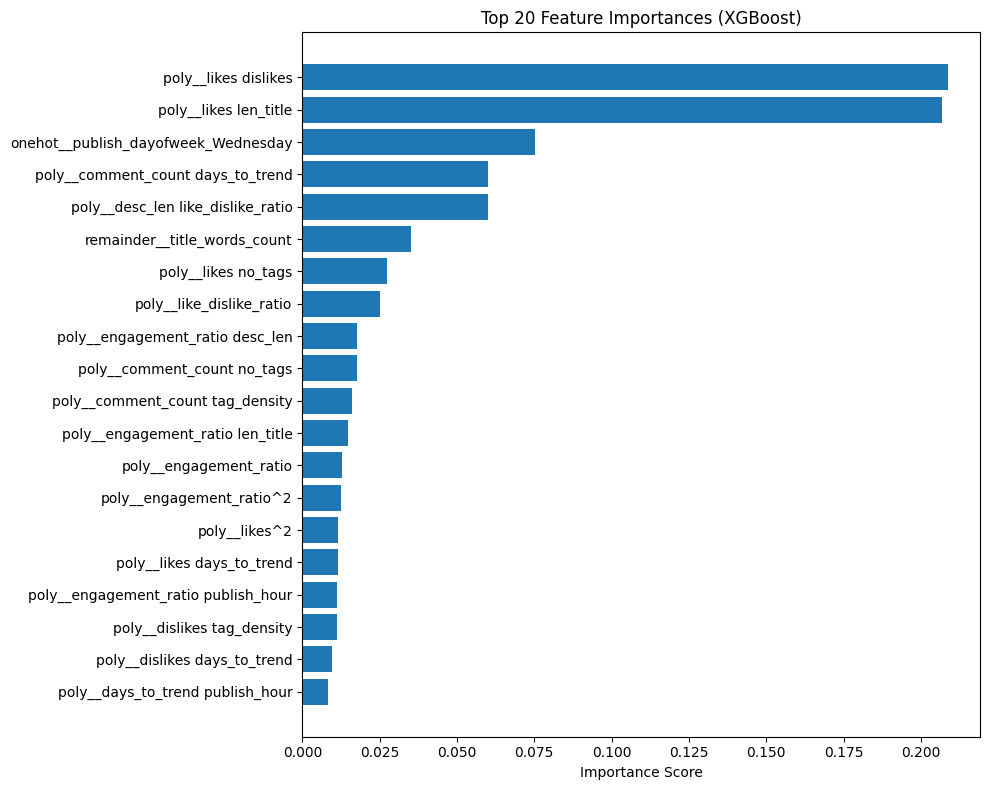

In [37]:
# Ambil preprocessor dan model dari pipeline
preprocessor_fitted = best_model_r2.named_steps['preprocessor']
model_fitted = best_model_r2.named_steps['model']

# Transform X menggunakan preprocessor
X_transformed = preprocessor_fitted.transform(X)

# Ambil nama semua fitur hasil preprocessing
feature_names = preprocessor_fitted.get_feature_names_out()

# Buat DataFrame importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_fitted.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Grafik ini menunjukkan fitur-fitur paling berpengaruh yang digunakan model `XGBoost` dalam memprediksi jumlah views video YouTube. Terlihat bahwa kombinasi antara jumlah `likes` dan `dislikes`, serta interaksi antara `likes` dengan panjang judul (`len_title`), menjadi faktor yang paling dominan. 

Artinya, model ini sangat mengandalkan sinyal dari seberapa banyak video disukai dan bagaimana judulnya disusun untuk memperkirakan performa view. Selain itu, faktor seperti **hari upload video—misalnya Rabu—juga cukup menentukan, bersama dengan jumlah komentar, rasio like/dislike, panjang deskripsi, dan berbagai kombinasi lainnya**. Secara keseluruhan, model lebih menyukai fitur-fitur hasil kombinasi (polynomial features) yang menggabungkan engagement penonton dengan karakteristik konten video.

# SHAP Value

100%|===================| 32459/32562 [03:14<00:00]       

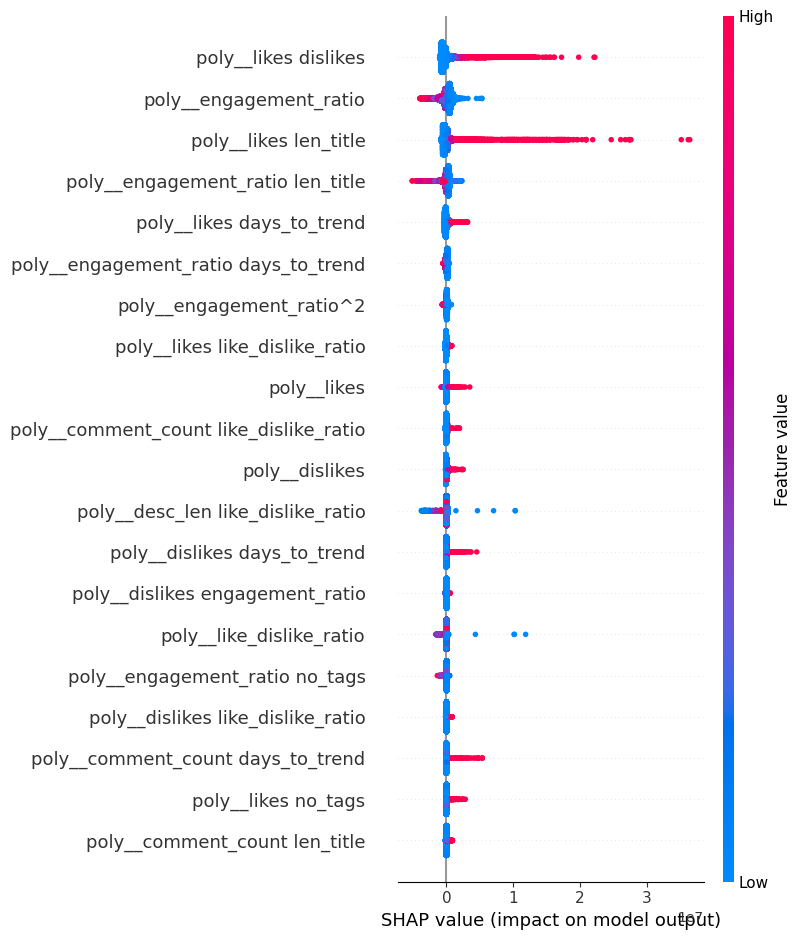

In [46]:
# Ambil model dari pipeline yang sudah di-fit
model_fitted = best_model_r2.named_steps['model']

# Ambil preprocessor dari pipeline yang sudah di-fit
preprocessor_fitted = best_model_r2.named_steps['preprocessor']

X_transformed = preprocessor_fitted.transform(X)
if hasattr(X_transformed, 'toarray'):
    X_transformed = X_transformed.toarray()
X_transformed = X_transformed.astype(np.float64)

explainer = shap.Explainer(model=model_fitted, masker=X_transformed)

# SHAP values
shap_values = explainer(X_transformed)

# Ambil nama semua fitur hasil preprocessing
feature_names = preprocessor_fitted.get_feature_names_out()

# Summary plot
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

Grafik SHAP value ini menggambarkan kontribusi setiap fitur terhadap output prediksi model pada tingkat individu (per video). Dari visualisasi tersebut, terlihat bahwa **fitur kombinasi antara `likes` dan `dislikes` memiliki pengaruh paling besar terhadap hasil prediksi**. Nilai SHAP yang tinggi untuk fitur ini, terutama ketika nilai `likes` dan `dislikes` tinggi (berwarna merah), cenderung **meningkatkan prediksi jumlah views secara signifikan**.

Fitur-fitur lain yang juga memberikan kontribusi besar adalah **`engagement_ratio`, interaksi antara `likes` dan panjang judul, serta gabungan antara `engagement_ratio` dan panjang judul**. Menariknya, fitur-fitur ini tidak hanya penting secara umum, tetapi juga menunjukkan bahwa semakin tinggi nilai fitur (ditandai dengan warna merah), semakin besar kontribusinya dalam meningkatkan prediksi views.

Sementara itu, fitur seperti `dislikes`, `comment_count`, dan berbagai rasio yang melibatkan panjang deskripsi, jumlah tag, atau waktu menuju trending juga memberikan pengaruh, meskipun dengan dampak yang cenderung lebih kecil.

Secara keseluruhan, model sangat bergantung pada metrik interaksi dan keterlibatan pengguna (`likes`, `dislikes, `engagement`), serta bagaimana fitur-fitur ini berpadu dengan elemen konten seperti panjang judul dan waktu trending. Ini memberikan wawasan bahwa performa video diukur bukan hanya dari satu metrik tunggal, tetapi dari kombinasi cerdas antara kualitas konten dan respons audiens.

# Save Model

In [36]:
import joblib

# Simpan pipeline model yang sudah dilatih dan di-tuning
joblib.dump(best_model_r2, 'xgboost_pipeline.pkl')

['xgboost_pipeline.pkl']

# Summary